In [1]:
# importing packages

import pandas as pd
import numpy as np
import os
import skimage
import sklearn
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import csv
import argparse
import cv2
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from sklearn import svm
from os import listdir
from os.path import isfile,join

In [5]:
def feature_extraction (file_path, image_files, mark, output_file):
    
    image = np.empty(len(image_files), dtype=object)

    for n in range(0,len(image_files)):
        
        # loading images with the help of cv2 module in the form of BGR

        image[n] = cv2.imread(join(file_path, image_files[n]))

        # converting BGR (BLUE, GREEN, RED) into HSV (HUE, SATURATION , VALUE) format
        ### BGR having intensity of color or related with color luminance which cannot separate colors so to separate colors so we use hsv

        # h stands for hue - used to measure wavelength found in dominant color
        # s stands for standard - measure size of amount of white light present in hue.


        image_hsv = cv2.cvtColor(image[n],cv2.COLOR_BGR2HSV)


        # separating the green color part in mask variable using cv2.inRange

        #(30,0,0) - lower bound for green region
        #(70,255,255) - upper bound for green color

        ## mask is containing value of green region
        mask = cv2.inRange(image_hsv,(30,0,0) ,(70,255,255)) 

        # taking out the ratio by dividing mask with whole imagesize

        ratio_of_green = cv2.countNonZero(mask)/(image.size/3)
        feature1 = np.round(ratio_of_green,2) 

        # Feature 2 amount of non-green colour in the picture

        feature2 = 1-feature1

        # cv2.split - it convert the hsv image into 3 different matrix sections of blue , green, red respectively.
        ##Each matrix is to dimensional-array

        ## feature3
        
        # converting the image into gray color
        image_gray = cv2.cvtColor(image[n],cv2.COLOR_BGR2GRAY)

        # fitting in gaussian curve
        gray = cv2.GaussianBlur(image_gray,(3,3),0)
        
        # able to find small spots in image with the help of otsu
        otsu, biny = cv2.threshold(gray,0,255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV )
        
        # help in defining the boundary
        contours, temp = cv2.findContours(biny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # taking out the perimeter of image
        peri = 0
        for c in contours:
            peri = peri + cv2.arcLength(c,True)
        feature3 = peri / 150


        ## feature 4
        
        # taking out the contrast from the background
        grey_scale = greycomatrix(image_gray,[1,2], [0, np.pi/2, 3*np.pi/4])
        contrast = greycoprops(grey_scale,"contrast")

        feature_4 = contrast[0][0]+contrast[0][1]+contrast[0][2]+contrast[1][0]+contrast[1][1]+contrast[1][2]
        feature_4 = feature_4/20000
        
        # writing data in csv file
        l = [int(mark),feature1,feature2,feature3,feature_4]
        out = open(output_file, "a")
        for row in l:
            out.write('%f,'%row)

        out.write("\n")
        out.close()


In [6]:
##### code for training

os.chdir ("E://Mtech programs/ACB/Project/Final_codes/training/")
files = os.listdir ('E://Mtech programs/ACB/Project/Final_codes/training/')
path = "E://Mtech programs/ACB/Project/Final_codes/training/"
output_file = 'training.csv'

####healthy mark -0 -327
##### diseased mark -1 -266

###code for test

# os.chdir ("/home/kajal/MTECH/ACB/PROJECT/dataset/test/")
# files = os.listdir ('/home/kajal/MTECH/ACB/PROJECT/dataset/test//')
# path = "/home/kajal/MTECH/ACB/PROJECT/dataset/test//"
# output_file = 'test.csv'

mark = 0

for i in files:
    
    # reading heathy and diseased images one by one which are different folders
    file_path = path + i
    
    image_files = [leaf for leaf in listdir(file_path) if isfile (join(file_path,leaf))]
    
    print('%r with label %r having %r numbers'%(i, mark, len(image_files)))
    
    # calling feature extracting function and saving data in given output file name
    feature_extraction(file_path, image_files, mark, output_file)
    
    # changing label for different dataset type
    mark = mark +1
    

'diseased' with label 0 having 266 numbers
'healthy' with label 1 having 327 numbers


# SVM Analysis for characterisation between healthy and diseased leaves

In [7]:
#### reading feature table 
#### producing full matrix, list of lables and list of list of features respectively

def label_featurematrix (input_file):
    
    training_csv = pd.read_csv(input_file, header = None)

    ### giving column names and refining data
    training_csv.columns = ['label', 'feature1', 'feature2', 'feature3','feature4','drop']
    training_csv = training_csv.drop(['drop'], axis = 1)
    training_csv = training_csv.astype({'label': int})

    ### creating label and feature list
    label = training_csv.label
    features_data = training_csv
    features_data = features_data.drop(['label'], axis = 'columns')
    
    return(training_csv, label, features_data)

In [9]:
## plotting graph between two features

def plot_graph_features (input_file, x_feature, y_feature): # named as feature1 or feature2 
    
    training_csv = pd.read_csv(input_file, header = None)

    ### giving column names and refining data
    training_csv.columns = ['label', 'feature1', 'feature2', 'feature3','feature4','drop']
    training_csv = training_csv.drop(['drop'], axis = 1)
    training_csv = training_csv.astype({'label': int})
    
    ### forming different dataframe on basis of label
    healthy = training_csv[training_csv.label == 0]
    diseased = training_csv[training_csv.label == 1]

    #### plotting graph between features
    
    print('Healthy with green and diseased with blue')
    plt.xlabel(x_feature,fontsize = 14)
    plt.ylabel(y_feature, fontsize = 14)
    
    # scatter plots
    plt.scatter(healthy[x_feature], healthy[y_feature],color='green',marker='+')
    plt.scatter(diseased[x_feature], diseased[y_feature],color='blue',marker='*')


Healthy with green and diseased with blue
474 474 119 119


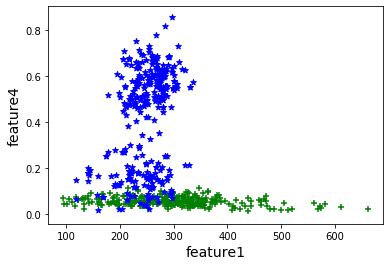

In [10]:
### for training dataset
os.chdir ("E://Mtech programs/ACB/Project/Final_codes/training/")
full, label, features_data = label_featurematrix ('training.csv')
plot_graph_features ('training.csv', 'feature1', 'feature4')

feature_train, feature_test, label_train, label_test = train_test_split(features_data, label, test_size = 0.2)
print(len(feature_train), len(label_train), len(feature_test), len(label_test))

In [8]:
# #### for testing dataset
# os.chdir ("/home/kajal/MTECH/ACB/PROJECT/dataset/test/")
# full_test, label_test,features_data_test = label_featurematrix ('test.csv')
# plot_graph_features ('test.csv', 'feature1', 'feature4')



In [16]:
## training the data with svm

classifi = svm.SVC(kernel = 'linear',C = 1.0, probability=True)
classifi.fit(feature_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
# predicting accuracy
pred_train = classifi.predict(feature_test)

accuracy = classifi.score(feature_test,label_test)
print("Score: %r" % accuracy)

tpfp = confusion_matrix(label_test, pred_train)

acc_score = accuracy_score(label_test, pred_train)
print("Accuracy score: %r" % accuracy)

print("Confusion matrix: %r" %tpfp)

Score: 0.9411764705882353
Accuracy score: 0.9411764705882353
Confusion matrix: array([[54,  2],
       [ 5, 58]], dtype=int64)


In [19]:
# roc curve
# probability
probab = classifi.predict_proba(feature_test)
probab = probab[:,0]
print(probab)

[1.47269804e-02 9.89696054e-01 9.69907330e-01 9.93165159e-01
 6.99551967e-01 7.44965472e-01 9.54426366e-01 3.54584498e-01
 8.34095754e-03 9.79550334e-03 9.30757302e-01 8.13408620e-02
 8.32995388e-02 5.38152623e-03 1.01283962e-02 2.45519010e-01
 8.99775781e-01 2.76886886e-02 7.90891508e-03 9.91342289e-01
 1.68105564e-02 2.99788078e-03 9.61297822e-01 8.53590937e-01
 8.60868421e-01 1.83605442e-01 6.42858701e-01 2.42041884e-06
 6.85661242e-02 2.64369868e-01 4.34517429e-02 9.35064117e-01
 9.83669903e-01 8.52169208e-01 2.57293969e-06 6.36701560e-07
 8.26762916e-01 9.98861816e-01 9.94798649e-01 3.35120452e-03
 9.68914864e-01 1.97797976e-06 9.40053759e-01 8.15519791e-02
 1.42309908e-02 1.27029435e-05 1.53139274e-07 9.90110938e-01
 1.16257375e-02 9.65986980e-01 2.08974337e-01 7.06043761e-07
 1.91744159e-05 2.63062014e-01 9.74057738e-01 9.66415094e-01
 5.42763762e-03 1.64307773e-01 8.95377287e-01 9.92170974e-01
 8.74338917e-01 2.51141572e-02 9.37956769e-01 2.82346259e-02
 9.67722281e-01 5.204871

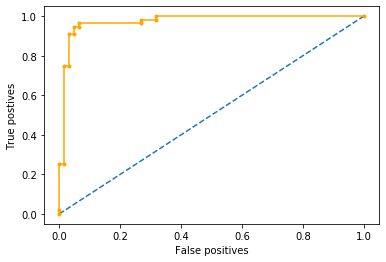

In [23]:

# false positive rate, true positive rate, threshold
fpr, tpr, thre = roc_curve(label_test, probab)

# plotting the graph
plt.plot([0,1],[0,1], linestyle = '--')

plt.xlabel("False positives")
plt.ylabel("True postives")

plt.plot(fpr, tpr, marker ='.', color ='orange')
